# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [ ]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.1/378.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.2 MB/s eta 0:00:00


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [ ]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [3]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-03-01 15:44:50--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2025-03-01 15:44:50 (15.4 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-03-01 15:44:50--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [5]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 2, 26, 15, 45, 0, 179180)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [6]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [7]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [8]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [9]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [10]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [11]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [12]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\''

In [13]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an ex-hitman who comes out of retirement to track down the gangsters that killed his dog and took everything from him. In seeking vengeance, he unleashes a maelstrom of destruction against those who wronged him and finds himself dragged into an impossible task. The legendary hitman is forced to unearth his identity and carry out a relentless vendetta. Throughout the movie, John Wick faces numerous challenges and battles against bounty-hunting killers and professional assassins seeking to claim the bounty on his head.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [14]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [15]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [16]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Opinions about John Wick seem to vary based on the reviews provided. Some people really enjoyed it, while others feel it was lacking or disappointing.'

In [17]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'There is no review with a rating of 10 in the provided context.'

In [18]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the action is beautifully choreographed, the setup is emotional for an action flick, and Keanu Reeves stars in it. It is highly recommended for those who enjoy action movies.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [19]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [20]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [21]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review_Title: A Masterpiece & Brilliant Sequel\n- Review_Url: [Click here to access the review](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the character John Wick, played by Keanu Reeves, gets pulled back into the world of crime and assassinations when a mobster named Santino D'Antonio forces him to complete a task that leads to a contract being put on his life. Wick then sets out to seek revenge and take down Santino."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [24]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [25]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [26]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick. The reviews mentioned how the film was slick, violent fun, full of stylish action sequences, and a welcomed return for Keanu Reeves to the genre. Reviewers highly recommended the movie, especially to action buffs, and praised the choreography, pacing, and overall entertainment value of the film.'

In [27]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'I\'m sorry, there are no reviews with a rating of 10 for the movie "John Wick 4."'

In [28]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, a retired assassin named John Wick, played by Keanu Reeves, comes out of retirement after someone kills his dog and steals his car. This leads to a lot of carnage as John seeks revenge and gets pulled back into the world of assassins. The story involves John traveling to various locations like Italy, Canada, and Manhattan, killing numerous assassins along the way to settle old debts and seek vengeance.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [29]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [30]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/tmp/ipykernel_59665/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [31]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [32]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [33]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [34]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Overall, people have generally liked the John Wick series.'

In [35]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review: \n\n- https://www.imdb.com/review/rw4854296/?ref_=tt_urv'

In [36]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, retired assassin John Wick comes out of retirement to seek vengeance when his dog is killed and his car is stolen. He ends up getting involved in a task to help take over the Assassin's Guild, traveling to Italy, Canada, and Manhattan to kill numerous assassins."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [37]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [38]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [39]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, it seems that people generally liked John Wick. The movie received positive comments such as "this marks the best action film of the year," "slick, violent fun," and "the action is beautifully choreographed." Overall, the reviews indicate that John Wick was well-received by viewers.'

In [40]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [41]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," an ex-hit-man comes out of retirement to seek vengeance against the gangsters who killed his dog and took everything from him. Throughout the movie, he faces numerous adversaries and engages in intense action sequences to achieve his goal of retribution.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [ ]:
#!pip install -qU langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [42]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [43]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [44]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [45]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [46]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [47]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, it seems that generally, people enjoyed the John Wick movies.'

In [48]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is one review with a rating of 10. Here is the URL to that review:\n- /review/rw4854296/?ref_=tt_urv\n\nIf you have any more questions or need further assistance, feel free to ask!'

In [49]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character seeks revenge on the people who took something he loved from him, which in this case was his dog. This sets off a chain of events involving action-packed sequences and intense confrontations with various antagonists.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [53]:
### YOUR CODE HERE

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator


generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())



generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)


Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node ba7b5e7c-fd0a-4268-8a3a-ec0dec87507c does not have a summary. Skipping filtering.
Node 02e5bad5-bb29-46bc-a4bf-4d7cc4e0f79c does not have a summary. Skipping filtering.
Node 6bf303a8-4ad5-4ea8-a04a-5a11301c2425 does not have a summary. Skipping filtering.
Node 870d8e98-ce0b-4fe5-8482-3529e4a8b3c7 does not have a summary. Skipping filtering.
Node 25d7c820-b86f-46d7-b865-3cc37629d568 does not have a summary. Skipping filtering.
Node 2ac5ed3b-1ba9-4447-a270-338e050f6df7 does not have a summary. Skipping filtering.
Node 44a487d9-4e71-49a3-8573-2ba2178cb7d2 does not have a summary. Skipping filtering.
Node 02180d9e-3a40-43ed-8288-866f2610cb52 does not have a summary. Skipping filtering.
Node b2582e93-bb5b-4355-b2e9-4917041c6ea6 does not have a summary. Skipping filtering.
Node 5fcdae62-166f-4dc4-ad02-ba9140ceedb4 does not have a summary. Skipping filtering.
Node 46bbf4ee-4875-4506-aa84-821d1d99860d does not have a summary. Skipping filtering.
Node 05505b54-65ab-438a-b486-cd25be92ebce d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [77]:
import pandas as pd

# Extract all questions from the dataset generated by Ragas
df_questions = pd.DataFrame({"Questions": [row.eval_sample.user_input for row in dataset]})

# Display the table
display(df_questions)

,Questions
0,How does John Wick compare to Liam Neeson's ro...
1,Whos Jon Wick?
2,Why Keanu so good in John Wick?
3,What role do Russian mobsters play in the movi...
4,Whoo is Jon Wick?
5,What makes the action sequences in John Wick s...
6,How does Ian McShane's character influence Joh...
7,What elements did John Wick 3 incorporate to c...
8,How does the action and style in 'John Wick: C...
9,Wut makes Keanu's action in John Wick so amazin?


We define our retrievers that we need to evaluate

In [54]:
retrieval_chains = {
    "BM25": bm25_retrieval_chain,
    "Naive": naive_retrieval_chain,
    "Multi-Query": multi_query_retrieval_chain,
    "Parent-Document": parent_document_retrieval_chain,
    "Contextual Compression": contextual_compression_retrieval_chain,
    "Ensemble": ensemble_retrieval_chain,
    "Semantic": semantic_retrieval_chain
}


We run our evaluation

In [58]:
import pandas as pd
from ragas import EvaluationDataset, evaluate, RunConfig
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
)
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage  # Import AIMessage for type checking

# Define evaluator model
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

# Set run config
custom_run_config = RunConfig(timeout=360)

# Dictionary to store evaluation results
retrieval_results = {}

# Evaluate each retrieval chain
for name, retrieval_chain in retrieval_chains.items():
    print(f"Evaluating {name} retriever...")

    # Generate responses using the retrieval chain
    for test_row in dataset:
        response = retrieval_chain.invoke({"question": test_row.eval_sample.user_input})

        # Extract response content safely
        test_row.eval_sample.response = (
            response["response"].content if isinstance(response["response"], AIMessage) else str(response["response"])
        )
        
        # Extract retrieved contexts
        test_row.eval_sample.retrieved_contexts = [
            context.page_content for context in response["context"]
        ]

    # Convert dataset to EvaluationDataset format
    evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

    # Run evaluation
    result = evaluate(
        dataset=evaluation_dataset,
        metrics=[
            LLMContextRecall(),
            Faithfulness(),
            FactualCorrectness(),
            ResponseRelevancy(),
            ContextEntityRecall(),
            NoiseSensitivity()
        ],
        llm=evaluator_llm,
        run_config=custom_run_config
    )

    # Store results
    retrieval_results[name] = result

# Convert results into a dataframe
df_results = pd.DataFrame(retrieval_results).T

# Display results
display(df_results)

# Visualization (optional)
import matplotlib.pyplot as plt

df_results.plot(kind="bar", figsize=(12, 6), title="Retriever Performance Metrics")
plt.xlabel("Retrievers")
plt.ylabel("Score")
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.show()


Evaluating BM25 retriever...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating Naive retriever...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


Evaluating Multi-Query retriever...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


Evaluating Parent-Document retriever...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating Contextual Compression retriever...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Evaluating Ensemble retriever...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


Evaluating Semantic retriever...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[44]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[50]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[41]: TimeoutError()


ValueError: If using all scalar values, you must pass an index

In [74]:
retrieval_results



{'BM25': {'context_recall': 0.4667, 'faithfulness': 0.4883, 'factual_correctness': 0.3400, 'answer_relevancy': 0.9471, 'context_entity_recall': 0.3533, 'noise_sensitivity_relevant': 0.2024},
 'Naive': {'context_recall': 0.7667, 'faithfulness': 0.7566, 'factual_correctness': 0.4140, 'answer_relevancy': 0.9467, 'context_entity_recall': 0.5367, 'noise_sensitivity_relevant': 0.5144},
 'Multi-Query': {'context_recall': 0.7667, 'faithfulness': 0.9357, 'factual_correctness': 0.3790, 'answer_relevancy': 0.8474, 'context_entity_recall': 0.4533, 'noise_sensitivity_relevant': 0.4333},
 'Parent-Document': {'context_recall': 0.4250, 'faithfulness': 0.6833, 'factual_correctness': 0.2660, 'answer_relevancy': 0.9512, 'context_entity_recall': 0.4333, 'noise_sensitivity_relevant': 0.3317},
 'Contextual Compression': {'context_recall': 0.5167, 'faithfulness': 0.7223, 'factual_correctness': 0.3200, 'answer_relevancy': 0.8432, 'context_entity_recall': 0.4333, 'noise_sensitivity_relevant': 0.3442},
 'Ensemb

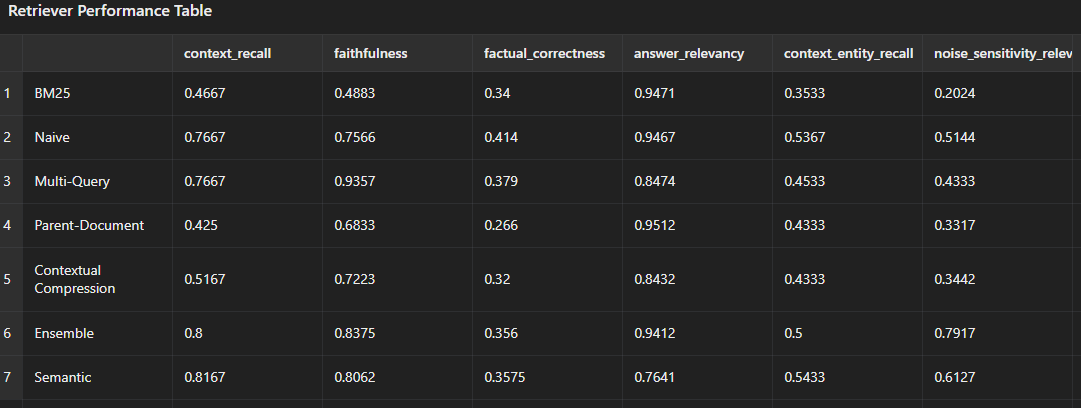

In [81]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain.schema.runnable import RunnableLambda

# Initialize LLM
llm = ChatOpenAI(temperature=0.7, model_name="gpt-4")

# Query Generation Chain (Updated)
prompt = PromptTemplate(
    input_variables=["original_query"],
    template="Generate 3 different ways to ask the following question:\n{original_query}",
)
query_generation_chain = prompt | llm  # NEW method replacing LLMChain

# RAG-Fusion Function
def rag_fusion(original_query, naive_retriever, llm):
    """ Performs RAG Fusion using reciprocal rank fusion (RRF) on retrieved documents. """
    try:
        # Generate alternative queries using the new method
        generated_queries = query_generation_chain.invoke({"original_query": original_query})
        generated_queries_list = generated_queries.content.strip().split("\n")
        generated_queries_list = [q.lstrip("123. ") for q in generated_queries_list if q.strip()]
    except Exception as e:
        print(f"Error generating queries: {e}")
        return "Error in query generation"

    # Retrieve documents using the new method
    retrieved_docs_per_query = []
    for query in generated_queries_list:
        docs = naive_retriever.invoke(query) if naive_retriever else []
        if docs:
            retrieved_docs_per_query.append(docs)

    if not retrieved_docs_per_query:
        return "No relevant documents found."

    # ✅ Fixed: Reciprocal Rank Fusion (RRF)
    def reciprocal_rank_fusion(retrieved_docs_per_query, k=60):
        """ Combines documents using RRF to improve retrieval diversity. """
        ranked_results = {}

        for docs in retrieved_docs_per_query:
            for rank, doc in enumerate(docs):
                # ✅ Use a hashable unique identifier (falling back to content preview if no metadata)
                doc_id = doc.metadata.get("source", doc.page_content[:50])  # Unique ID for document
                
                if doc_id not in ranked_results:
                    ranked_results[doc_id] = {"score": 0, "document": doc}  # Store document reference
                
                ranked_results[doc_id]["score"] += 1 / (rank + k)

        # ✅ Sort based on score
        fused_results = sorted(ranked_results.values(), key=lambda x: x["score"], reverse=True)
        
        # ✅ Return only documents (not just identifiers)
        return [entry["document"] for entry in fused_results]

    fused_docs = reciprocal_rank_fusion(retrieved_docs_per_query)

    # ✅ Construct context from top-ranked documents
    context = "\n".join([doc.page_content for doc in fused_docs[:5]])  # Top 5 docs

    # ✅ Structured prompt for LLM
    prompt_text = f"""
    You are an expert AI assistant. Use the following retrieved context to answer the user's question.

    Context:
    {context}

    Question: {original_query}
    Answer:
    """

    try:
        answer = llm.invoke(prompt_text)  # ✅ Use .invoke() instead of direct call
    except Exception as e:
        print(f"Error generating response: {e}")
        return "Error in LLM response"

    return answer

# Sample dataset iteration
if "dataset" not in locals():
    dataset = []  # Placeholder dataset

for test_row in dataset:
    user_question = test_row.eval_sample.user_input
    response = rag_fusion(user_question, naive_retriever, llm)
    print(f"Question: {user_question}")
    print(f"Response: {response}")
    print("-" * 40)  # Separator for readability

# Display the generated RAGAS dataset
print("\nGenerated RAGAS Dataset:")
print(dataset)


Question: How does John Wick compare to Liam Neeson's role in Taken?
Response: content="John Wick, played by Keanu Reeves, is compared to Liam Neeson's role in Taken in terms of the premise of seeking revenge for a loved one taken from them. In Taken, Liam Neeson's character seeks to rescue his daughter, while in John Wick, Keanu Reeves seeks revenge for his dog. Both are action movies with a simple premise revolving around a relatable hero." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 522, 'total_tokens': 603, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-ba69b44e-d2ea-458c-997e-58d49339bb4f-0' usage_metadata={'input_tokens': 522, 'output_tokens': 81, 'to